In [6]:
import overpy
op = overpy.Overpass()
import geopandas as gp
import pandas as pd
from shapely.geometry import shape, Polygon,LineString, MultiPolygon
from shapely.ops import polygonize
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
import utils.close_holes
import utils.osm

In [20]:
bb = "(33.85972509642107,35.46144957007879,33.91857725200028,35.572185442725925)"

osm_data = op.query(f"""
[timeout:25];
(
  way["highway"="motorway"]{bb};
  way["highway"="trunk"]{bb};
  way["highway"="primary"]{bb};
  way["highway"="secondary"]{bb};
  way["highway"="tertiary"]{bb};
  way["highway"="residential"]{bb};
  //  way["highway"="unclassified"]{bb};
  //  way[building]{bb};
  way["natural"="water"]{bb};
  way[waterway]{bb};
  relation["landuse"="residential"]{bb};
  relation["admin_level"="4"]{bb};
  relation["admin_level"="7"]{bb};
);
(._;>;);
out body;
""")

In [22]:

def nodes_to_linestring(nodes):
	points = [(n.lon, n.lat) for n in nodes]
	return LineString(points)

def nodes_to_polygon(nodes):
	points = [(n.lon, n.lat) for n in nodes]
	return Polygon(points)

def area_ro_polygons(area):
	return area

streets_dict = [{
    'id': way.id,
	'highway': way.tags.get("highway"),
    'geometry': nodes_to_linestring(way.nodes),
} for way in list(filter(lambda x: x.tags.get("highway") != None, osm_data.ways))]
streets = gp.GeoDataFrame(streets_dict, crs="EPSG:4326")

water_dict = [{
    'id': way.id,
	'natural': way.tags.get("natural"),
    'geometry': nodes_to_linestring(way.nodes),
} for way in list(filter(lambda x: x.tags.get("waterway") != None, osm_data.ways))]
water = gp.GeoDataFrame(water_dict, crs="EPSG:4326")

built_area_dict = [{
    'id': area.id,
	'landuse': area.tags.get("landuse"),
    'geometry': utils.osm.rel_to_multipolygon(osm_data, area),
} for area in list(filter(lambda x: x.tags.get("landuse") != None, osm_data.relations))]
built_area = gp.GeoDataFrame(built_area_dict, crs="EPSG:4326")

tram_lines = gp.read_file("./data/beirut-trams.geojson", crs="EPSG:4326")

# buildings_dict = [{
#     'id': way.id,
# 	'building': way.tags.get("building"),
#     'geometry': nodes_to_polygon(way.nodes),
# } for way in list(filter(lambda x: x.tags.get("building") != None, osm_data.ways))]
# buildings = gp.GeoDataFrame(buildings_dict, crs="EPSG:4326")


boundary_dict = [{
    'id': rel.id,
	'name': rel.tags.get("name"),
	'name_en': rel.tags.get("name:en"),
	'name_de': rel.tags.get("name:de"),
	'boundary': rel.tags.get("boundary"),
	'admin_level': rel.tags.get("admin_level"),
    'geometry': utils.osm.rel_to_multipolygon(osm_data, rel),
} for rel in list(filter(lambda x: x.tags.get("boundary") == "administrative", osm_data.relations))]

bounds = gp.GeoDataFrame(boundary_dict, crs="EPSG:4326")

streets.to_file("./tmp/beirut_streets.geojson")
water.to_file("./tmp/beirut_water.geojson")
bounds.to_file("./tmp/beirut_bounds.geojson")
built_area.to_file("./tmp/beirut_built_area.geojson")


<Axes: >

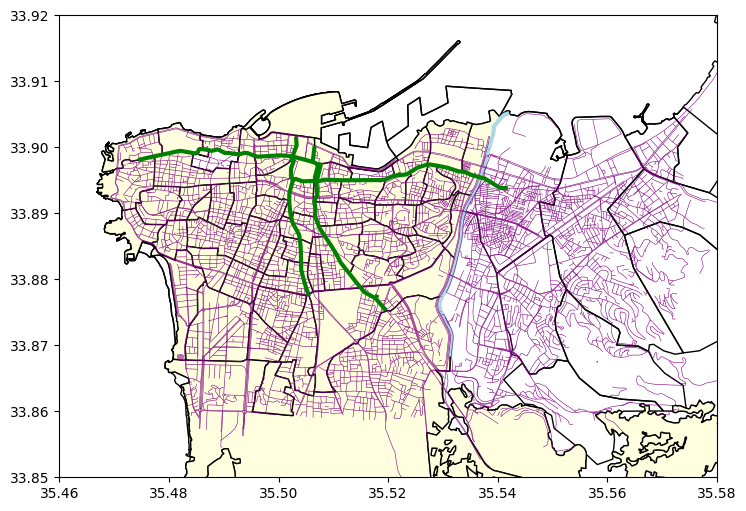

In [17]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim([35.46,35.58])
ax.set_ylim([33.85, 33.92])

streets.plot(ax=ax, color="purple", lw=.4, zorder=10)
bounds.plot(ax=ax, edgecolor='black', color="none", zorder=-10)
water.plot(ax=ax, color="lightblue", lw=3)
built_area.plot(ax=ax, color="lightyellow", edgecolor="black")
tram_lines.plot(ax=ax, lw=3, zorder=10, color="green")
